# 21. Martingale Theory Deep Dive

**Goal:** Explore four cornerstones of discrete-time martingale theory through rigorous
statements, simulations, and numerical verification.

**Topics covered:**
1. **Optional Stopping Theorem** -- when does $E[M_\tau] = E[M_0]$?
2. **Doob's Decomposition** -- every submartingale = martingale + predictable increasing process
3. **Doob's Maximal Inequality** -- tail bounds on $\max_{k \le n} M_k$
4. **Upcrossing Inequality & Convergence** -- counting upcrossings to prove a.s. convergence

**Prerequisites:** Notebook 10 (Martingale Convergence), Notebook 20 (Conditional Expectation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'figure.dpi': 100, 'font.size': 10})

## 1. Optional Stopping Theorem

Let $(M_n)_{n \ge 0}$ be a martingale with respect to a filtration $(\mathcal{F}_n)$,
and let $\tau$ be a stopping time (i.e., $\{\tau \le n\} \in \mathcal{F}_n$ for all $n$).

**Theorem (Optional Stopping).** If any of the following sufficient conditions holds:
- (a) $\tau$ is **bounded**: $\tau \le N$ a.s. for some deterministic $N$, or
- (b) $E[\tau] < \infty$ and there exists $c > 0$ with $E[|M_{n+1} - M_n| \mid \mathcal{F}_n] \le c$ a.s.,

then $E[M_\tau] = E[M_0]$.

**Key point:** Without boundedness or integrability conditions, the theorem **fails**.
The classic counterexample is the **gambler's ruin** stopping time
$\tau = \inf\{n : S_n = a\}$ for a simple random walk $S_n$ starting at $0$.
Here $\tau < \infty$ a.s. (for $a > 0$) but $E[\tau] = \infty$, and
$E[M_\tau] = a \ne 0 = E[M_0]$.

We verify the theorem for **bounded** stopping times and demonstrate its
**failure** for the unbounded gambler's ruin stopping time.

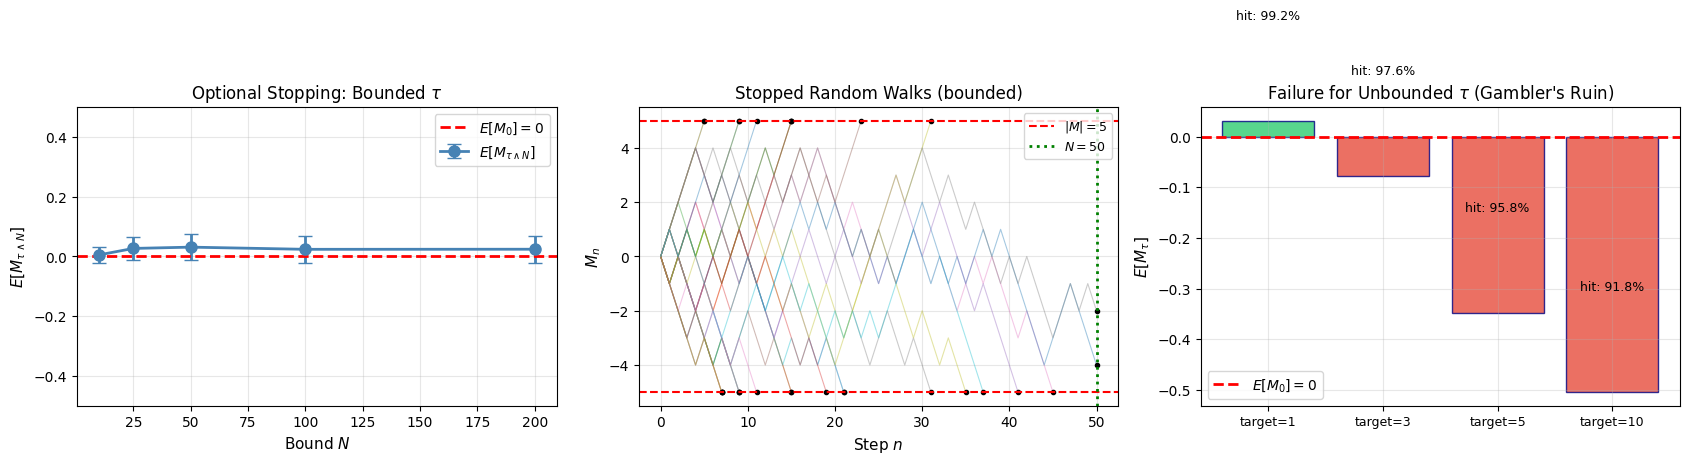

--- Bounded stopping time: E[M_{tau ^ N}] ---
  N=  10: E[M_tau] = +0.0053  (SE = 0.0137)
  N=  25: E[M_tau] = +0.0269  (SE = 0.0188)
  N=  50: E[M_tau] = +0.0312  (SE = 0.0214)
  N= 100: E[M_tau] = +0.0239  (SE = 0.0223)
  N= 200: E[M_tau] = +0.0242  (SE = 0.0224)

--- Unbounded stopping time (gambler's ruin): E[M_tau] != 0 ---
  target= 1: E[M_tau] = +0.0314,  P(hit by 10000) = 0.9923,  E[tau | hit] = 80.9
  target= 3: E[M_tau] = -0.0779,  P(hit by 10000) = 0.9758,  E[tau | hit] = 236.4
  target= 5: E[M_tau] = -0.3474,  P(hit by 10000) = 0.9580,  E[tau | hit] = 389.9
  target=10: E[M_tau] = -0.5042,  P(hit by 10000) = 0.9177,  E[tau | hit] = 761.4


In [2]:
np.random.seed(42)
n_paths = 50_000

# --- Part A: Bounded stopping time ---
# Simple random walk M_n = sum of +/-1 steps
# Stopping time: tau = min(first time |M_n| >= 5, N) for various bounds N
N_max = 200
steps = np.random.choice([-1, 1], size=(n_paths, N_max))
walks = np.cumsum(steps, axis=1)
walks = np.column_stack([np.zeros(n_paths), walks])  # prepend M_0 = 0

threshold = 5
# Find first hitting time of |M_n| >= threshold (unbounded version)
hit_times_unbounded = np.full(n_paths, N_max, dtype=int)
for i in range(n_paths):
    hits = np.where(np.abs(walks[i]) >= threshold)[0]
    if len(hits) > 0:
        hit_times_unbounded[i] = hits[0]

# For bounded stopping times, cap at N
bounds = [10, 25, 50, 100, 200]
results_bounded = []
for N in bounds:
    tau = np.minimum(hit_times_unbounded, N)
    M_tau = walks[np.arange(n_paths), tau]
    results_bounded.append((N, np.mean(M_tau), np.std(M_tau) / np.sqrt(n_paths)))

# --- Part B: Unbounded stopping time (gambler's ruin) ---
# tau = first time S_n = target (one-sided), run for a very long time
N_long = 10_000
targets = [1, 3, 5, 10]
steps_long = np.random.choice([-1, 1], size=(n_paths, N_long))
walks_long = np.cumsum(steps_long, axis=1)
walks_long = np.column_stack([np.zeros(n_paths), walks_long])

results_unbounded = []
for target in targets:
    tau_vals = np.full(n_paths, N_long, dtype=int)
    for i in range(n_paths):
        hits = np.where(walks_long[i] >= target)[0]
        if len(hits) > 0:
            tau_vals[i] = hits[0]
    M_tau = walks_long[np.arange(n_paths), tau_vals]
    frac_hit = np.mean(tau_vals < N_long)
    results_unbounded.append((target, np.mean(M_tau), frac_hit, np.mean(tau_vals[tau_vals < N_long]) if frac_hit > 0 else np.inf))

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Bounded stopping -- E[M_tau] vs bound N
ax = axes[0]
Ns = [r[0] for r in results_bounded]
means = [r[1] for r in results_bounded]
sems = [r[2] for r in results_bounded]
ax.errorbar(Ns, means, yerr=[2*s for s in sems], fmt='o-', color='steelblue',
            linewidth=2, markersize=8, capsize=5, label=r'$E[M_{\tau \wedge N}]$')
ax.axhline(0, color='red', linestyle='--', linewidth=2, label=r'$E[M_0] = 0$')
ax.set_xlabel('Bound $N$', fontsize=11)
ax.set_ylabel(r'$E[M_{\tau \wedge N}]$', fontsize=11)
ax.set_title('Optional Stopping: Bounded $\\tau$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)

# Panel 2: Sample paths with bounded stopping
ax = axes[1]
N_demo = 50
for i in range(30):
    tau_i = min(hit_times_unbounded[i], N_demo)
    path = walks[i, :tau_i + 1]
    ax.plot(range(len(path)), path, alpha=0.4, linewidth=0.8)
    ax.plot(tau_i, walks[i, tau_i], 'ko', markersize=3)
ax.axhline(threshold, color='red', linestyle='--', linewidth=1.5, label=f'$|M| = {threshold}$')
ax.axhline(-threshold, color='red', linestyle='--', linewidth=1.5)
ax.axvline(N_demo, color='green', linestyle=':', linewidth=2, label=f'$N = {N_demo}$')
ax.set_xlabel('Step $n$', fontsize=11)
ax.set_ylabel('$M_n$', fontsize=11)
ax.set_title('Stopped Random Walks (bounded)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Unbounded stopping -- E[M_tau] = target != 0
ax = axes[2]
tgts = [r[0] for r in results_unbounded]
means_ub = [r[1] for r in results_unbounded]
fracs = [r[2] for r in results_unbounded]
colors = ['#2ecc71' if f > 0.99 else '#e74c3c' for f in fracs]
bars = ax.bar(range(len(tgts)), means_ub, color=colors, edgecolor='navy', alpha=0.8)
ax.set_xticks(range(len(tgts)))
ax.set_xticklabels([f'target={t}' for t in tgts], fontsize=9)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label=r'$E[M_0] = 0$')
ax.set_ylabel(r'$E[M_\tau]$', fontsize=11)
ax.set_title('Failure for Unbounded $\\tau$ (Gambler\'s Ruin)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
for i, (t, m, f, _) in enumerate(results_unbounded):
    ax.text(i, m + 0.2, f'hit: {f*100:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print('--- Bounded stopping time: E[M_{tau ^ N}] ---')
for N, m, s in results_bounded:
    print(f'  N={N:>4d}: E[M_tau] = {m:+.4f}  (SE = {s:.4f})')
print()
print('--- Unbounded stopping time (gambler\'s ruin): E[M_tau] != 0 ---')
for t, m, f, avg_t in results_unbounded:
    print(f'  target={t:>2d}: E[M_tau] = {m:+.4f},  P(hit by {N_long}) = {f:.4f},  E[tau | hit] = {avg_t:.1f}')

## 2. Doob's Decomposition Theorem

**Theorem (Doob's Decomposition).** Every adapted integrable process $(X_n)_{n \ge 0}$
admits a unique decomposition
$$X_n = M_n + A_n,$$
where:
- $M_n$ is a **martingale** ($E[M_{n+1} \mid \mathcal{F}_n] = M_n$),
- $A_n$ is **predictable** ($A_n$ is $\mathcal{F}_{n-1}$-measurable) with $A_0 = 0$.

If $X_n$ is a **submartingale**, then $A_n$ is **increasing** (non-decreasing).

**Explicit formulas:**
$$A_n = \sum_{k=0}^{n-1} \bigl(E[X_{k+1} \mid \mathcal{F}_k] - X_k\bigr), \qquad M_n = X_n - A_n.$$

**Example:** Let $B_n$ be a simple random walk (martingale). Then $X_n = B_n^2$ is a
submartingale since $E[B_{n+1}^2 \mid \mathcal{F}_n] = B_n^2 + 1$.

The Doob decomposition gives:
$$B_n^2 = \underbrace{(B_n^2 - n)}_{M_n \text{ (martingale)}} + \underbrace{n}_{A_n \text{ (predictable drift)}}.$$

<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
/var/folders/22/xxwj0_711b34fsf64tkzj_ph0000gn/T/ipykernel_55147/2501300188.py:79: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$E[X_{n+1} - X_n \mid B_n=b]$', fontsize=11)


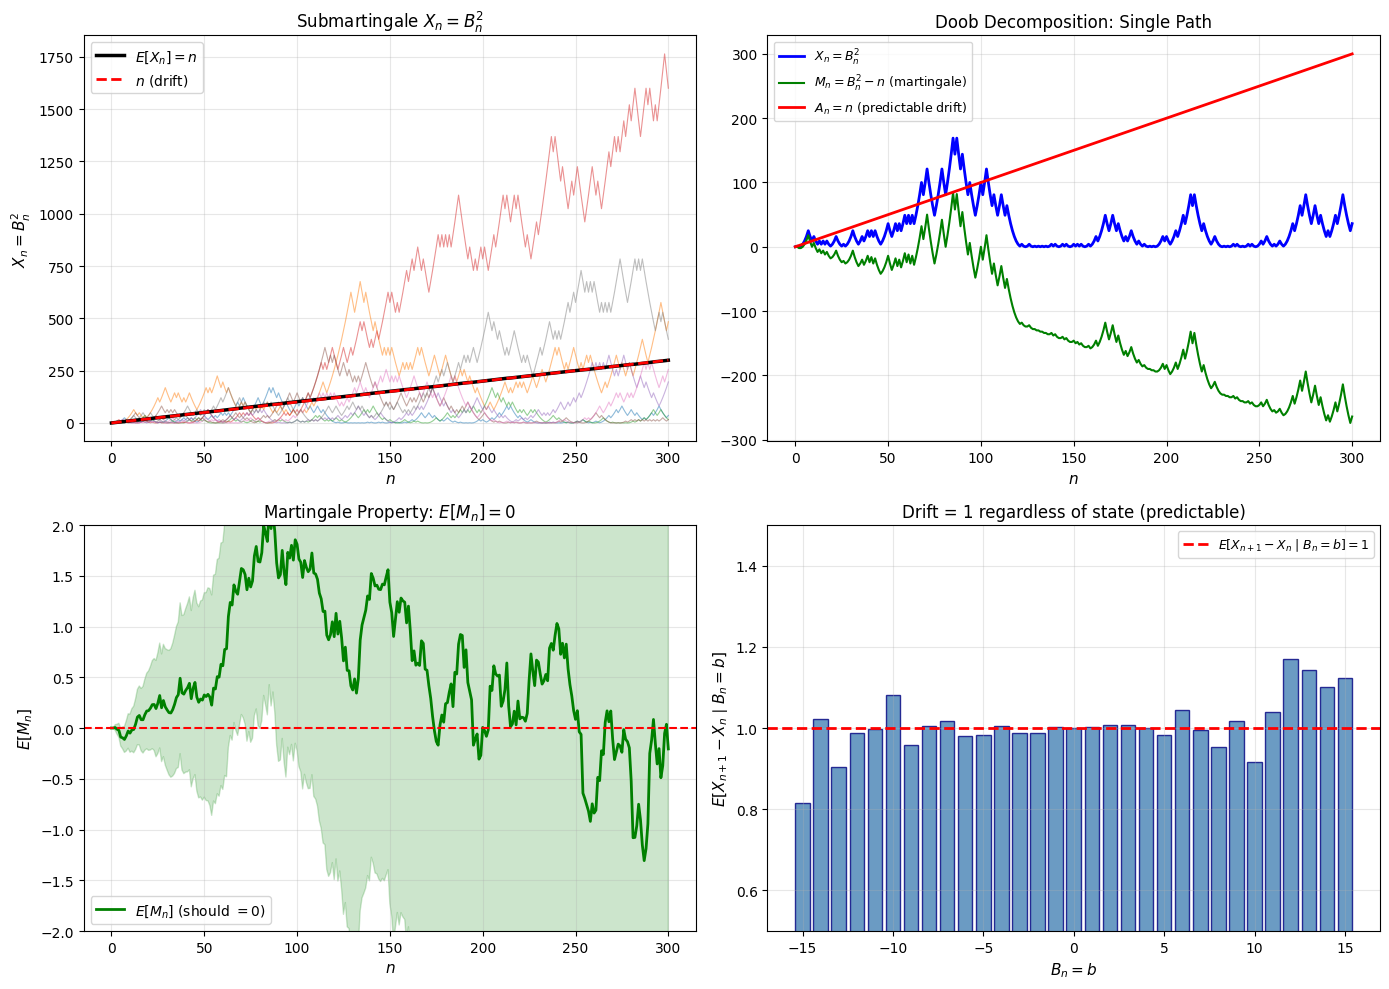

E[M_n] at n=300: -0.2058 (should be 0)
E[X_n] at n=300: 299.79 (should be 300)
Mean conditional increment E[X_{n+1} - X_n | B_n]: 1.0075 (should be 1.0)


In [3]:
np.random.seed(123)
n_steps = 300
n_paths = 20_000

# Simple random walk B_n
increments = np.random.choice([-1, 1], size=(n_paths, n_steps))
B = np.column_stack([np.zeros(n_paths), np.cumsum(increments, axis=1)])

# Submartingale X_n = B_n^2
X = B**2

# Doob decomposition: A_n = n (deterministic), M_n = B_n^2 - n
time = np.arange(n_steps + 1)
A = time[np.newaxis, :]                # predictable increasing part
M = X - A                              # martingale part = B_n^2 - n

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Sample paths of X_n = B_n^2
ax = axes[0, 0]
for i in range(8):
    ax.plot(time, X[i], alpha=0.5, linewidth=0.8)
ax.plot(time, np.mean(X, axis=0), 'k-', linewidth=2.5, label=r'$E[X_n] = n$')
ax.plot(time, time, 'r--', linewidth=2, label='$n$ (drift)')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel('$X_n = B_n^2$', fontsize=11)
ax.set_title('Submartingale $X_n = B_n^2$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Decomposition for a single path
ax = axes[0, 1]
idx = 0
ax.plot(time, X[idx], 'b-', linewidth=2, label='$X_n = B_n^2$')
ax.plot(time, M[idx], 'g-', linewidth=1.5, label='$M_n = B_n^2 - n$ (martingale)')
ax.plot(time, A[idx], 'r-', linewidth=2, label='$A_n = n$ (predictable drift)')
ax.set_xlabel('$n$', fontsize=11)
ax.set_title('Doob Decomposition: Single Path', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: Verify M_n is a martingale -- E[M_n] = 0 for all n
ax = axes[1, 0]
E_M = np.mean(M, axis=0)
E_X = np.mean(X, axis=0)
ax.plot(time, E_M, 'g-', linewidth=2, label=r'$E[M_n]$ (should $= 0$)')
ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
se_M = np.std(M, axis=0) / np.sqrt(n_paths)
ax.fill_between(time, E_M - 2*se_M, E_M + 2*se_M, alpha=0.2, color='green')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel(r'$E[M_n]$', fontsize=11)
ax.set_title('Martingale Property: $E[M_n] = 0$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-2, 2)

# Panel 4: Verify predictability -- A_{n+1} is F_n-measurable
# Since A_n = n is deterministic, verify by checking increment
# E[X_{n+1} | F_n] - X_n = E[B_{n+1}^2 | F_n] - B_n^2 = 1 (deterministic)
ax = axes[1, 1]
# Compute empirical E[X_{n+1} - X_n | B_n = b] for various b values
b_vals = np.arange(-15, 16)
cond_increments = []
for b in b_vals:
    # Collect all transitions from B_n = b
    mask = (B[:, :-1] == b)
    if mask.sum() > 100:
        x_incr = (X[:, 1:] - X[:, :-1])[mask]
        cond_increments.append(np.mean(x_incr))
    else:
        cond_increments.append(np.nan)

valid_mask = ~np.isnan(cond_increments)
ax.bar(b_vals[valid_mask], np.array(cond_increments)[valid_mask],
       color='steelblue', edgecolor='navy', alpha=0.8)
ax.axhline(1.0, color='red', linestyle='--', linewidth=2,
           label=r'$E[X_{n+1} - X_n \mid B_n = b] = 1$')
ax.set_xlabel('$B_n = b$', fontsize=11)
ax.set_ylabel('$E[X_{n+1} - X_n \mid B_n=b]$', fontsize=11)
ax.set_title('Drift = 1 regardless of state (predictable)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()

print(f'E[M_n] at n=300: {E_M[-1]:.4f} (should be 0)')
print(f'E[X_n] at n=300: {E_X[-1]:.2f} (should be {n_steps})')
print(f'Mean conditional increment E[X_{{n+1}} - X_n | B_n]: {np.nanmean(cond_increments):.4f} (should be 1.0)')

## 3. Doob's Maximal Inequality

Let $(M_n)$ be a non-negative submartingale. Then for any $\lambda > 0$:

**$L^1$ Maximal Inequality:**
$$P\!\left(\max_{0 \le k \le n} M_k \ge \lambda\right) \le \frac{E[M_n^+]}{\lambda} = \frac{E[M_n]}{\lambda}.$$

**$L^p$ Maximal Inequality** (for $p > 1$): If $M_n \in L^p$, then
$$E\!\left[\max_{0 \le k \le n} |M_k|^p\right] \le \left(\frac{p}{p-1}\right)^{\!p} E[|M_n|^p].$$

We verify both inequalities numerically using a simple random walk
(where $M_n^+ = |S_n|$ is a submartingale by Jensen's inequality applied
to the convex function $x \mapsto |x|$) and an exponential martingale.

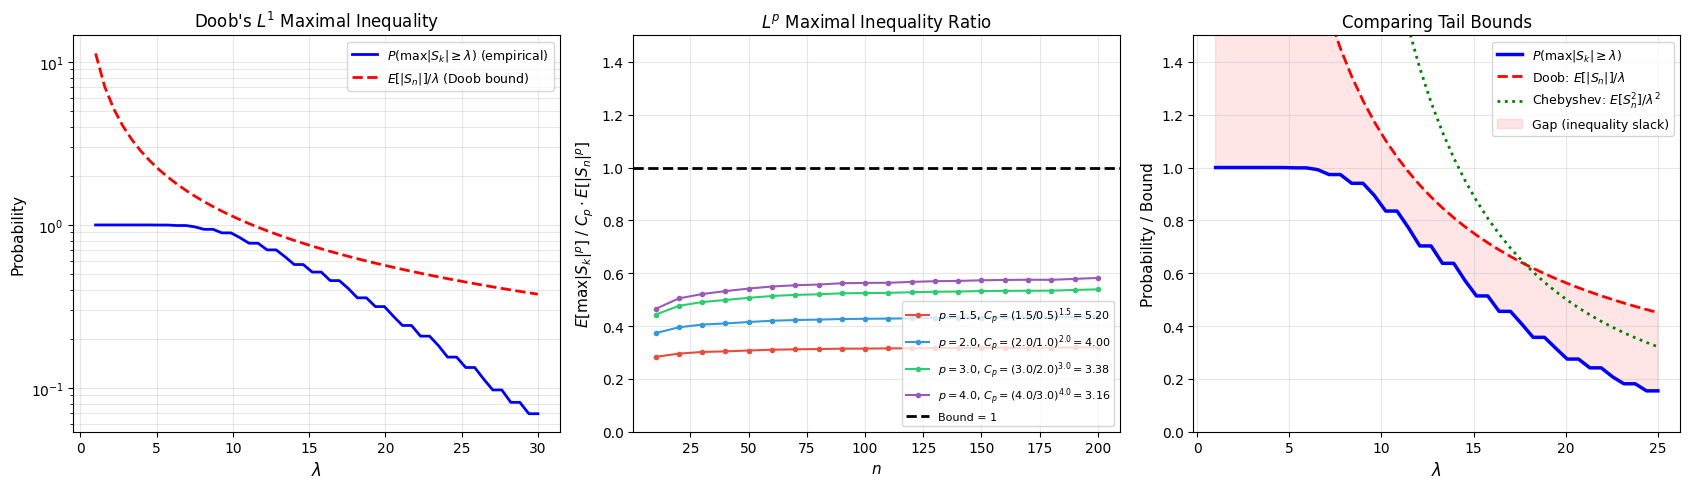

E[|S_n|] at n=200: 11.277
Theoretical E[|S_n|] ~ sqrt(2n/pi) = 11.284
L^2 ratio at n=200: E[max|S|^2] / (4 * E[S_n^2]) = 0.4359 (should be <= 1)


In [4]:
np.random.seed(314)
n_steps = 200
n_paths = 100_000

# Simple random walk S_n
increments = np.random.choice([-1, 1], size=(n_paths, n_steps))
S = np.column_stack([np.zeros(n_paths), np.cumsum(increments, axis=1)])

# Non-negative submartingale: |S_n|
absS = np.abs(S)
max_absS = np.max(absS, axis=1)  # max_{k<=n} |S_k|

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# --- Panel 1: L^1 maximal inequality ---
ax = axes[0]
lambdas = np.linspace(1, 30, 50)
empirical_prob = np.array([np.mean(max_absS >= lam) for lam in lambdas])
doob_bound = np.mean(absS[:, -1]) / lambdas  # E[|S_n|] / lambda
# Markov bound on |S_n| alone
markov_bound = np.array([np.mean(absS[:, -1] >= lam) for lam in lambdas])

ax.semilogy(lambdas, empirical_prob, 'b-', linewidth=2, label=r'$P(\max |S_k| \geq \lambda)$ (empirical)')
ax.semilogy(lambdas, doob_bound, 'r--', linewidth=2, label=r'$E[|S_n|] / \lambda$ (Doob bound)')
ax.set_xlabel('$\\lambda$', fontsize=12)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title("Doob's $L^1$ Maximal Inequality", fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')

# --- Panel 2: L^p maximal inequality ---
ax = axes[1]
p_values = [1.5, 2.0, 3.0, 4.0]
n_vals = np.arange(10, n_steps + 1, 10)
colors_p = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for p, color in zip(p_values, colors_p):
    Cp = (p / (p - 1))**p
    ratios = []
    for n_val in n_vals:
        max_p = np.mean(np.max(absS[:, :n_val+1], axis=1)**p)
        final_p = np.mean(absS[:, n_val]**p)
        ratios.append(max_p / (Cp * final_p) if final_p > 0 else 0)
    ax.plot(n_vals, ratios, 'o-', color=color, markersize=3, linewidth=1.5,
            label=f'$p={p}$, $C_p = ({p}/{p-1})^{{{p}}} = {Cp:.2f}$')

ax.axhline(1.0, color='black', linestyle='--', linewidth=2, label='Bound = 1')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel(r'$E[\max|S_k|^p] \;/\; C_p \cdot E[|S_n|^p]$', fontsize=11)
ax.set_title("$L^p$ Maximal Inequality Ratio", fontsize=12)
ax.legend(fontsize=8, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.5)

# --- Panel 3: Tightness exploration ---
# Compare Doob bound, Markov's inequality, and exact probability
ax = axes[2]
lambdas2 = np.linspace(1, 25, 40)
emp_max_prob = np.array([np.mean(max_absS >= lam) for lam in lambdas2])
doob = np.mean(absS[:, -1]) / lambdas2
# Chebyshev-like bound using variance
chebyshev = np.mean(S[:, -1]**2) / lambdas2**2  # E[S_n^2]/lambda^2

ax.plot(lambdas2, emp_max_prob, 'b-', linewidth=2.5, label=r'$P(\max|S_k| \geq \lambda)$')
ax.plot(lambdas2, doob, 'r--', linewidth=2, label=r'Doob: $E[|S_n|]/\lambda$')
ax.plot(lambdas2, chebyshev, 'g:', linewidth=2, label=r'Chebyshev: $E[S_n^2]/\lambda^2$')
ax.fill_between(lambdas2, emp_max_prob, doob, alpha=0.1, color='red', label='Gap (inequality slack)')
ax.set_xlabel('$\\lambda$', fontsize=12)
ax.set_ylabel('Probability / Bound', fontsize=11)
ax.set_title('Comparing Tail Bounds', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.5)

plt.tight_layout()
plt.show()

print(f'E[|S_n|] at n={n_steps}: {np.mean(absS[:, -1]):.3f}')
print(f'Theoretical E[|S_n|] ~ sqrt(2n/pi) = {np.sqrt(2*n_steps/np.pi):.3f}')
print(f'L^2 ratio at n={n_steps}: E[max|S|^2] / (4 * E[S_n^2]) = {np.mean(max_absS**2) / (4 * np.mean(S[:,-1]**2)):.4f} (should be <= 1)')

### Maximal Inequality for Exponential Martingales

The exponential martingale $E_n = \exp\!\bigl(\theta S_n - n \log \cosh(\theta)\bigr)$
(where $S_n$ is a simple random walk) is a non-negative martingale with $E[E_n] = 1$.

This is especially useful because Doob's $L^1$ inequality applied to $E_n$ gives
the **exponential tail bound:**
$$P\!\left(\max_{k \le n} S_k \ge x\right) \le e^{-\theta x + n \log \cosh(\theta)}$$
for any $\theta > 0$. Optimizing over $\theta$ yields sub-Gaussian tail decay.

We verify the maximal inequality $P(\max_{k \le n} E_k \ge \lambda) \le 1/\lambda$
and compare the exponential tail bound to empirical probabilities.

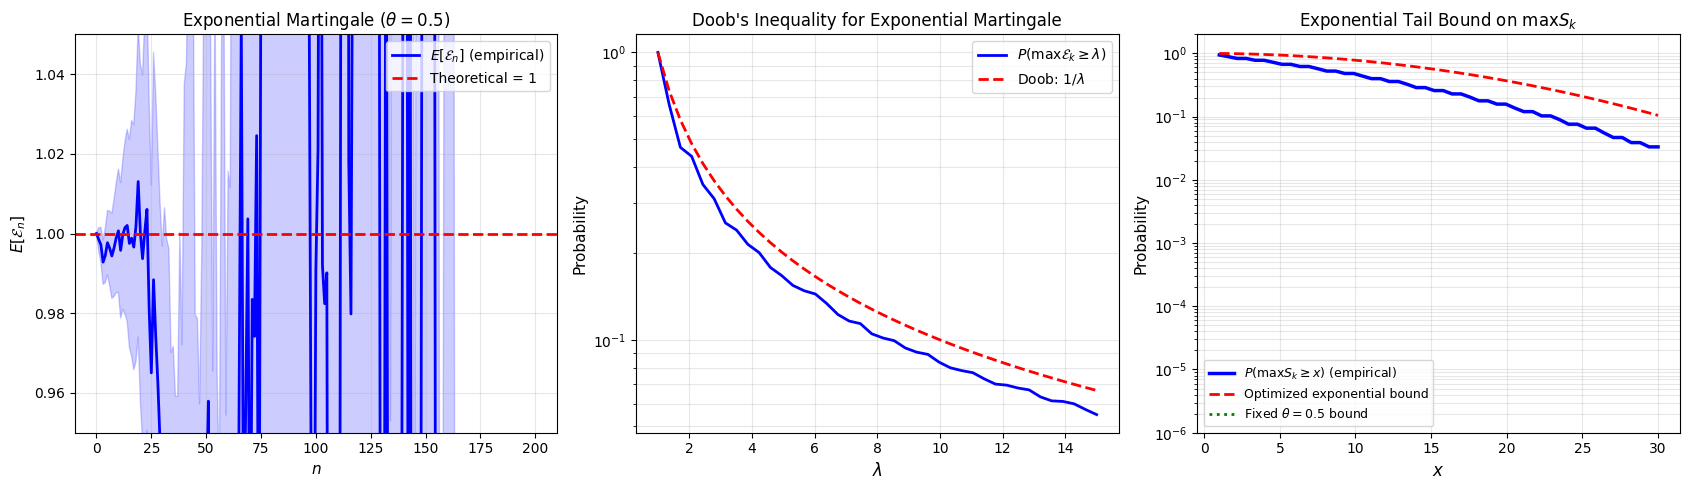

E[E_n] at n=200: 0.023965 (should be 1.0)
P(max E_k >= 5): 0.1673, Doob bound: 0.2000
P(max E_k >= 10): 0.0836, Doob bound: 0.1000


In [5]:
np.random.seed(271)
n_steps_exp = 200
n_paths_exp = 100_000

# Simple random walk
inc_exp = np.random.choice([-1, 1], size=(n_paths_exp, n_steps_exp))
S_exp = np.column_stack([np.zeros(n_paths_exp), np.cumsum(inc_exp, axis=1)])

theta = 0.5
log_cosh = np.log(np.cosh(theta))

# Exponential martingale: E_n = exp(theta * S_n - n * log(cosh(theta)))
time_exp = np.arange(n_steps_exp + 1)
Exp_mart = np.exp(theta * S_exp - time_exp[np.newaxis, :] * log_cosh)
max_Exp = np.max(Exp_mart, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Verify E_n is a martingale (E[E_n] = 1)
ax = axes[0]
E_exp = np.mean(Exp_mart, axis=0)
se_exp = np.std(Exp_mart, axis=0) / np.sqrt(n_paths_exp)
ax.plot(time_exp, E_exp, 'b-', linewidth=2, label=r'$E[\mathcal{E}_n]$ (empirical)')
ax.fill_between(time_exp, E_exp - 2*se_exp, E_exp + 2*se_exp, alpha=0.2, color='blue')
ax.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Theoretical = 1')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel(r'$E[\mathcal{E}_n]$', fontsize=11)
ax.set_title(f'Exponential Martingale ($\\theta = {theta}$)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.95, 1.05)

# Panel 2: Doob's inequality for E_n: P(max E_k >= lam) <= 1/lam
ax = axes[1]
lam_exp = np.linspace(1, 15, 40)
emp_prob_exp = np.array([np.mean(max_Exp >= l) for l in lam_exp])
doob_exp = 1.0 / lam_exp  # E[E_n]/lam = 1/lam

ax.semilogy(lam_exp, emp_prob_exp, 'b-', linewidth=2,
            label=r'$P(\max \mathcal{E}_k \geq \lambda)$')
ax.semilogy(lam_exp, doob_exp, 'r--', linewidth=2,
            label=r'Doob: $1/\lambda$')
ax.set_xlabel('$\\lambda$', fontsize=12)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title("Doob's Inequality for Exponential Martingale", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# Panel 3: Exponential tail bound on max S_k
ax = axes[2]
x_vals = np.linspace(1, 30, 50)
max_S_exp = np.max(S_exp, axis=1)
emp_tail = np.array([np.mean(max_S_exp >= x) for x in x_vals])

# Optimal theta for each x: theta* = argmin theta*x - n*log(cosh(theta))
# For simple RW with n steps, optimize numerically
from scipy.optimize import minimize_scalar
opt_bounds = []
for x in x_vals:
    res = minimize_scalar(lambda th: -th * x + n_steps_exp * np.log(np.cosh(th)),
                          bounds=(0.001, 3.0), method='bounded')
    opt_bounds.append(np.exp(res.fun))

# Fixed theta bound
fixed_bound = np.exp(-theta * x_vals + n_steps_exp * log_cosh)

ax.semilogy(x_vals, emp_tail, 'b-', linewidth=2.5, label=r'$P(\max S_k \geq x)$ (empirical)')
ax.semilogy(x_vals, opt_bounds, 'r--', linewidth=2, label='Optimized exponential bound')
ax.semilogy(x_vals, fixed_bound, 'g:', linewidth=2, label=f'Fixed $\\theta = {theta}$ bound')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('Probability', fontsize=11)
ax.set_title('Exponential Tail Bound on $\\max S_k$', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which='both')
ax.set_ylim(1e-6, 2)

plt.tight_layout()
plt.show()

print(f'E[E_n] at n={n_steps_exp}: {E_exp[-1]:.6f} (should be 1.0)')
print(f'P(max E_k >= 5): {np.mean(max_Exp >= 5):.4f}, Doob bound: {1/5:.4f}')
print(f'P(max E_k >= 10): {np.mean(max_Exp >= 10):.4f}, Doob bound: {1/10:.4f}')

## 4. Upcrossing Inequality and a.s. Convergence

**Definition.** Given a sequence $(X_n)$ and an interval $[a, b]$, an **upcrossing**
is a pair of times $s < t$ such that $X_s \le a$ and $X_t \ge b$ (the process
crosses from below $a$ to above $b$). Let $U_n([a, b])$ denote the number of
upcrossings of $[a, b]$ by time $n$.

**Doob's Upcrossing Inequality.** If $(X_n)$ is a submartingale, then
$$(b - a)\, E[U_n([a, b])] \le E[(X_n - a)^-] \le E[|X_n|] + |a|.$$

**Connection to Convergence.** If $\sup_n E[X_n^+] < \infty$, then for any
rationals $a < b$, $U_\infty([a, b]) < \infty$ a.s. This implies $\liminf X_n = \limsup X_n$
a.s., giving **Doob's Martingale Convergence Theorem**: an $L^1$-bounded
martingale converges almost surely.

We simulate submartingales, count upcrossings, and verify the inequality.

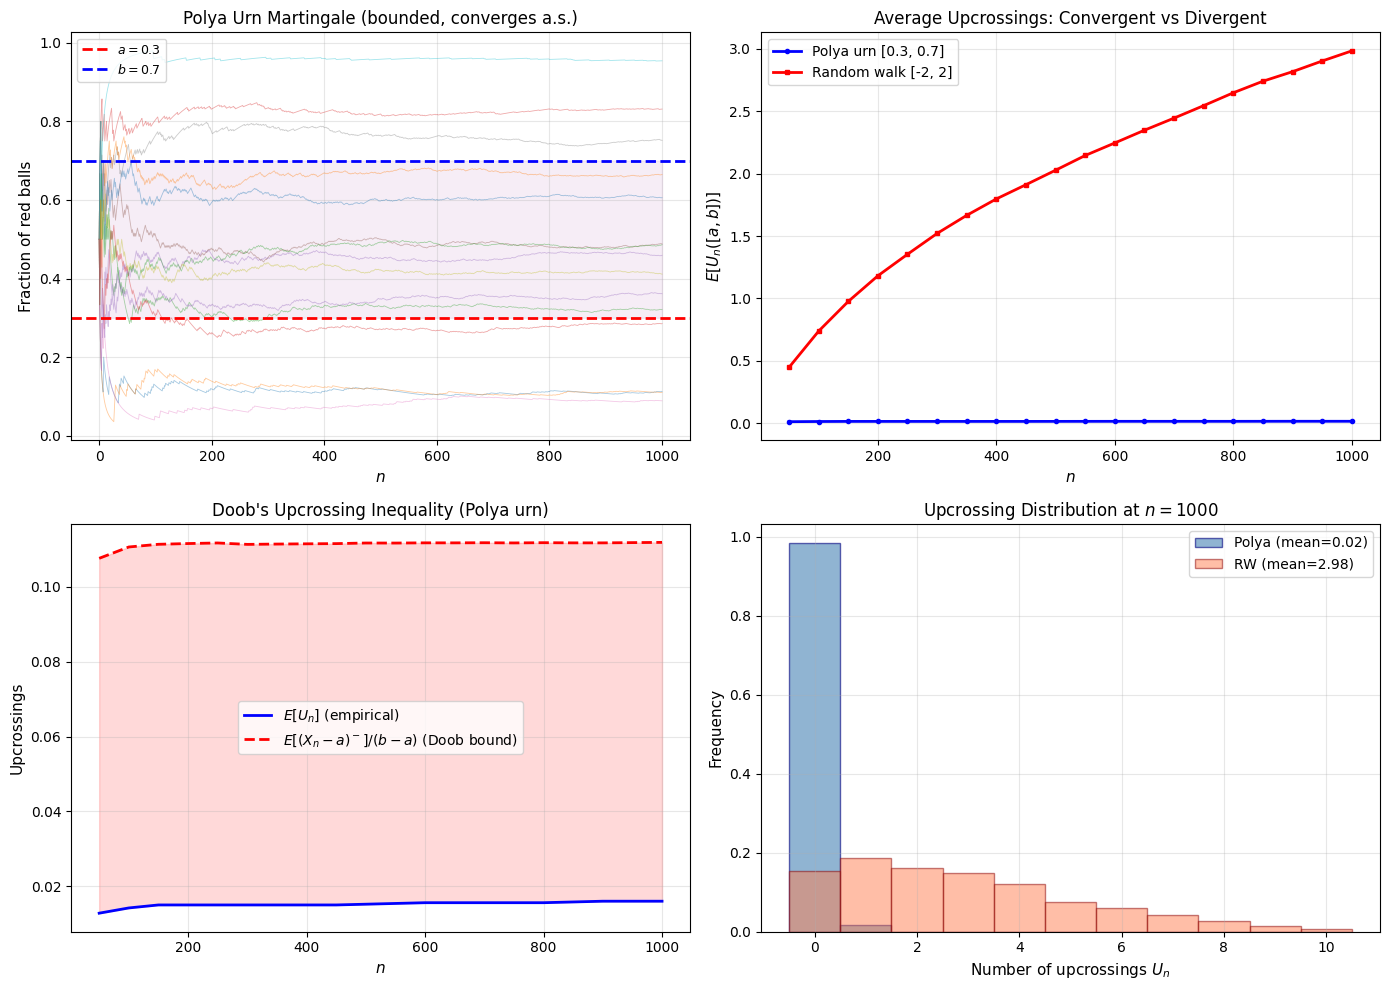

Polya urn: mean upcrossings of [0.3, 0.7] at n=1000: 0.016
  Doob bound: 0.112
  Finite upcrossings => a.s. convergence confirmed

Random walk: mean upcrossings of [-2, 2] at n=1000: 2.983
  Upcrossings grow => no a.s. convergence (as expected for recurrent RW)


In [6]:
np.random.seed(2024)


def count_upcrossings(path, a, b):
    """Count the number of upcrossings of [a, b] in a path."""
    n_up = 0
    below = True  # start looking for entry below a
    for x in path:
        if below and x <= a:
            below = False  # entered below a, now look for exit above b
        elif not below and x >= b:
            n_up += 1
            below = True   # completed upcrossing, look for next entry below a
    return n_up


# --- Simulation 1: L^1-bounded martingale (converges) ---
# Use a bounded random walk reflected at +/- L (stays bounded in L^1)
# Actually, use a Polya urn fraction (bounded [0,1] martingale)
n_steps = 1000
n_paths = 5000
red = np.ones(n_paths)
blue = np.ones(n_paths)
polya = np.zeros((n_paths, n_steps + 1))
polya[:, 0] = 0.5

for t in range(n_steps):
    frac = red / (red + blue)
    polya[:, t] = frac
    draw_red = np.random.uniform(0, 1, n_paths) < frac
    red += draw_red
    blue += ~draw_red
polya[:, n_steps] = red / (red + blue)

# Count upcrossings of [0.3, 0.7] at increasing times
a_val, b_val = 0.3, 0.7
time_points = np.arange(50, n_steps + 1, 50)
avg_upcrossings = []
upcrossing_bound = []

for t in time_points:
    ucs = np.array([count_upcrossings(polya[i, :t+1], a_val, b_val) for i in range(n_paths)])
    avg_upcrossings.append(np.mean(ucs))
    # Doob bound: E[U_n] <= E[(X_n - a)^-] / (b - a)
    neg_part = np.mean(np.maximum(a_val - polya[:, t], 0))
    upcrossing_bound.append(neg_part / (b_val - a_val))

# --- Simulation 2: Simple random walk (not L^1 bounded, upcrossings grow) ---
rw_increments = np.random.choice([-1, 1], size=(n_paths, n_steps))
rw = np.column_stack([np.zeros(n_paths), np.cumsum(rw_increments, axis=1)])
a_rw, b_rw = -2, 2
avg_up_rw = []
bound_rw = []

for t in time_points:
    ucs = np.array([count_upcrossings(rw[i, :t+1], a_rw, b_rw) for i in range(min(2000, n_paths))])
    avg_up_rw.append(np.mean(ucs))
    # For |S_n| submartingale with interval [a_rw, b_rw] on S_n itself
    neg_part = np.mean(np.maximum(a_rw - rw[:, t], 0))
    bound_rw.append(neg_part / (b_rw - a_rw))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Polya urn sample paths with upcrossing interval
ax = axes[0, 0]
for i in range(15):
    ax.plot(polya[i], alpha=0.4, linewidth=0.6)
ax.axhline(a_val, color='red', linestyle='--', linewidth=2, label=f'$a = {a_val}$')
ax.axhline(b_val, color='blue', linestyle='--', linewidth=2, label=f'$b = {b_val}$')
ax.fill_between(range(n_steps + 1), a_val, b_val, alpha=0.07, color='purple')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel('Fraction of red balls', fontsize=11)
ax.set_title('Polya Urn Martingale (bounded, converges a.s.)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Average upcrossings -- bounded martingale vs random walk
ax = axes[0, 1]
ax.plot(time_points, avg_upcrossings, 'b-o', linewidth=2, markersize=3,
        label=f'Polya urn [{a_val}, {b_val}]')
ax.plot(time_points, avg_up_rw, 'r-s', linewidth=2, markersize=3,
        label=f'Random walk [{a_rw}, {b_rw}]')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel('$E[U_n([a, b])]$', fontsize=11)
ax.set_title('Average Upcrossings: Convergent vs Divergent', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 3: Upcrossing inequality verification (Polya urn)
ax = axes[1, 0]
ax.plot(time_points, avg_upcrossings, 'b-', linewidth=2, label=r'$E[U_n]$ (empirical)')
ax.plot(time_points, upcrossing_bound, 'r--', linewidth=2, label=r'$E[(X_n - a)^-] / (b-a)$ (Doob bound)')
ax.fill_between(time_points, avg_upcrossings, upcrossing_bound, alpha=0.15, color='red')
ax.set_xlabel('$n$', fontsize=11)
ax.set_ylabel('Upcrossings', fontsize=11)
ax.set_title("Doob's Upcrossing Inequality (Polya urn)", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 4: Distribution of upcrossings at final time
ax = axes[1, 1]
final_ucs_polya = np.array([count_upcrossings(polya[i], a_val, b_val) for i in range(n_paths)])
final_ucs_rw = np.array([count_upcrossings(rw[i], a_rw, b_rw) for i in range(min(2000, n_paths))])

max_uc = max(int(np.percentile(final_ucs_polya, 99)), int(np.percentile(final_ucs_rw, 99)))
bins = np.arange(0, max_uc + 2) - 0.5
ax.hist(final_ucs_polya, bins=bins, density=True, alpha=0.6, color='steelblue',
        edgecolor='navy', label=f'Polya (mean={np.mean(final_ucs_polya):.2f})')
ax.hist(final_ucs_rw, bins=bins, density=True, alpha=0.5, color='coral',
        edgecolor='darkred', label=f'RW (mean={np.mean(final_ucs_rw):.2f})')
ax.set_xlabel('Number of upcrossings $U_n$', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Upcrossing Distribution at $n={n_steps}$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Polya urn: mean upcrossings of [{a_val}, {b_val}] at n={n_steps}: {np.mean(final_ucs_polya):.3f}')
print(f'  Doob bound: {upcrossing_bound[-1]:.3f}')
print(f'  Finite upcrossings => a.s. convergence confirmed')
print(f'\nRandom walk: mean upcrossings of [{a_rw}, {b_rw}] at n={n_steps}: {np.mean(final_ucs_rw):.3f}')
print(f'  Upcrossings grow => no a.s. convergence (as expected for recurrent RW)')

## Key Takeaways

1. **Optional Stopping Theorem:** For bounded stopping times $\tau \le N$, the identity
   $E[M_\tau] = E[M_0]$ holds for any martingale. Without boundedness conditions, the
   identity can fail spectacularly (gambler's ruin gives $E[M_\tau] = a \ne 0$).

2. **Doob's Decomposition:** Every submartingale uniquely decomposes as
   martingale + predictable increasing process. For $B_n^2$, this gives
   $B_n^2 = (B_n^2 - n) + n$, cleanly separating the noise from the deterministic
   drift.

3. **Doob's Maximal Inequality:** Provides sharp control on the running maximum of
   a martingale: $P(\max M_k \ge \lambda) \le E[M_n]/\lambda$. The $L^p$ version
   $E[\max|M_k|^p] \le C_p \cdot E[|M_n|^p]$ with $C_p = (p/(p-1))^p$ is crucial
   for proving convergence in $L^p$.

4. **Upcrossing Inequality:** The expected number of upcrossings of any interval
   $[a, b]$ is bounded by $E[(X_n - a)^-]/(b-a)$. For $L^1$-bounded martingales
   this bound remains finite as $n \to \infty$, forcing $\liminf X_n = \limsup X_n$
   a.s. and giving Doob's Convergence Theorem.

5. **Convergence vs Recurrence:** Bounded martingales (Polya urn) make finitely many
   upcrossings and converge a.s. Recurrent random walks make infinitely many
   upcrossings and do not converge, consistent with the theory since $E[|S_n|]
   \to \infty$ provides no finite upcrossing bound.